Thinking about moving to a more metro city such as toronto? Want to know which neighborhoods to avoid? 
<br>
<br>
This EDA was inspired by yet another news story on all the catalytic converter thefts in Edmonton. <br>
Unfortunately, I could not find a proper dataset for crime statistics that was publicly available for Edmonton, let alone Alberta,<br>
and I happened to come across the Toronto Police Service Public Safety Portal on accident. <br><br>

While unfortunate, this does provide the opportunity to generate some insights for prospective migrators to toronto.

In [2]:
import os
import pandas as pd
import numpy as np
import janitor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Step 1. Importing the Dataset
Data set was grabbed from the TPSPS Portal. It is mostly clean, but will need to be verified

In [3]:
os.chdir(r"C:\Users\Justin\Desktop\GitPool\Toronto Crime Statistics\data")
df = pd.read_csv('Major_Crime_Indicators.csv')

Step 2. "Cleaning the Dataset". Mostly making changes for style as everything already looks standardized

In [4]:
df.head(5)
#Immediately, I can see that I won't need the x, y, index, or objectids. so those will be dropped.
dropped = df.drop(columns=['X', 'Y', 'Index_', 'ObjectId']);

In [5]:
#Now to clean the titles and make them look nice and uniform
cleaned_df = dropped.clean_names(case_type='lower')
cleaned_df.columns;

In [6]:
#Checking for nas
cleaned_df.isnull().sum()
cleaned_df[cleaned_df.occurrenceyear.isnull()].head(n=5);
#The nulls appear to be from old crimes where the date and time were not recorded. Its not an error in the data, and will be included
#Overall, the data looks pretty clean, and they probably have some form of electronic recording system for standardization.


Step 3. Querying and Visualizations <br>
Order of queries will be things such as:<br>
1. Distribution of crimes that occur based on location, premises type, neighborhood. ()
2. Total Count of crimes by year. and by mci category
3. What sort of offences are in each mci category. Whats the distribution?
4. Length of time between crime occuring and reporting (make sure to remove the nas for this one)
5. Which division reports the most crimes? Which neighborhoods do the these divisions service
6. Specifically for stolen vehicle crimes(stolen catalytic converters), whats the most common time that they occur

There are more many more queries that I could generate off this data, but these are just questions that the common migrator would probably want to know the answer to. 
Tableau or Power BI would probably be better for this sort of thing, but its good practice for the seaborn package.

In [7]:
dff = cleaned_df
dff.groupby('location_type')['location_type'].count().sort_values(ascending = False).head(20);
#Most crimes occur in apartment complexes or shared living environments, or single homes rather than public spaces. Although the nature of these crimes merit some investigation
dff[dff['location_type']== 'Apartment (Rooming House, Condo)'].groupby('mci_category')['mci_category'].count()
#The vast majority of crimes in this category is assault, which is rather depressing. All other categories relate to theft, but those only make up 25%

mci_category
Assault            50679
Auto Theft          1053
Break and Enter    16089
Robbery             2533
Theft Over          1707
Name: mci_category, dtype: int64

In [8]:
#So the location type wasn't great. Too many categories to easily plop into a visualization. Thankfully, they categorized it for us.
dff.groupby('premises_type')['premises_type'].count().sort_values(ascending = False);
#With so few categories, a visualization would be a great way of seeing trends
crimes_by_premise = dff.groupby(['mci_category','premises_type'])['mci_category'].count().sort_values(ascending = False)

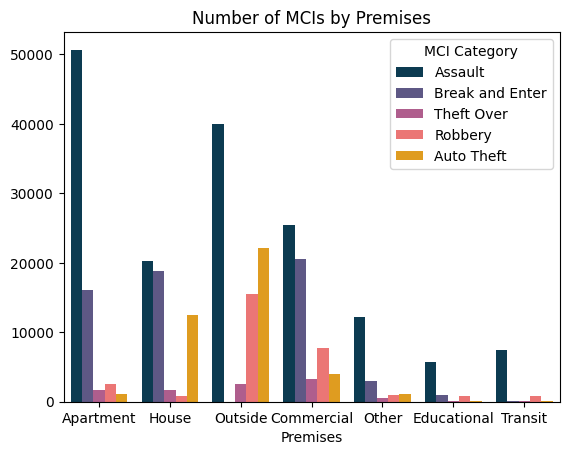

In [9]:
#Plot 
sns.countplot(data = dff, x='premises_type' , hue = 'mci_category', orient = 'h', palette=['#003f5c', '#58508d','#bc5090','#ff6361','#ffa600'])

plt.title("Number of MCIs by Premises")
plt.ylabel("")
plt.xlabel("Premises")
plt.legend(title = "MCI Category")

So most assaults happen in apartments or outside. However, we can't make conclusions on whether houses are safer than apartments as we don't know the population <br>
living in each. Fortunately, statistics canada can answer that, with 40% of toronto's population residing in single-unit houses while the rest are split between condos and apartments in 2016. <br>
With more than double the number of assaults, we can presume that single target houses are more prone to theft, but far safer when looking out for assault related crimes.

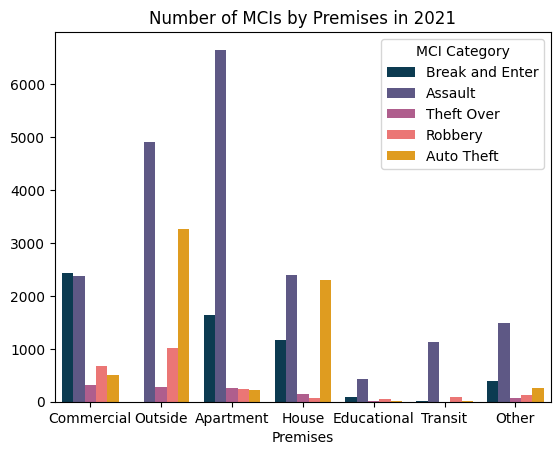

In [10]:
#Data only goes up to June of 2022. But if we wanted a more current graph for just 2022, well...here it is.
dff2021 = dff[dff['reportedyear']==2021]

sns.countplot(data = dff2021, x='premises_type' , hue = 'mci_category', orient = 'h', palette=['#003f5c', '#58508d','#bc5090','#ff6361','#ffa600'])

plt.title("Number of MCIs by Premises in 2021")
plt.ylabel("")
plt.xlabel("Premises")
plt.legend(title = "MCI Category")

In [11]:
#For the neighborhood rankings, we could do something different
ndff = dff2021['neighbourhood'].value_counts()
counts = ndff.reset_index(name= 'counts')
ranked = ndff.rank(method='dense', ascending=False).reset_index(name='rank')

pdf = pd.merge(counts, ranked, on= 'index')
spdf = pd.merge(pdf, dff[['neighbourhood','longitude', 'latitude']], left_on = 'index', right_on = 'neighbourhood', how = 'left')

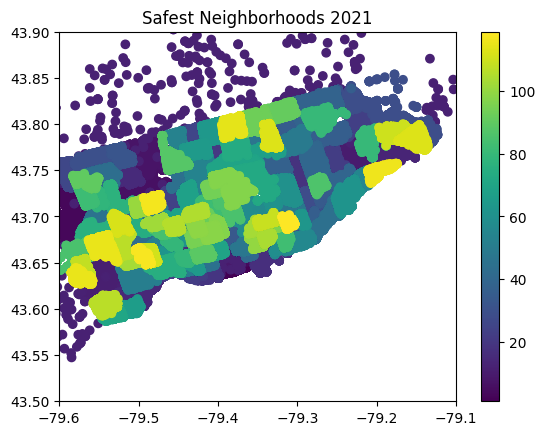

In [12]:
plt.scatter(spdf['longitude'], spdf['latitude'], c=spdf['rank'], cmap='viridis')

plt.colorbar()
plt.xlim(-79.6, -79.1)
plt.ylim(43.5, 43.9)
plt.title('Safest Neighborhoods 2021')
plt.show()

The 5 neighbourhoods with the highest incidence of crimes of all types are: 
* Waterfront Communities-The Islands
* Church-Yonge Corridor
* Bay Street Corridor
* West Humber-Clairville	
* Moss Park	

The lowest incidences are in :
* Lambton Baby Point
* Woodbine-Lumsden
* Maple Leaf
* Guildwood
* Princess-Rosethorn


As for where they are on the map. That is something that a slicer in Tableau would have been able to solve.
<br> Although we can also search up the communities ourselves
<br>
3.2. Crimes by Year

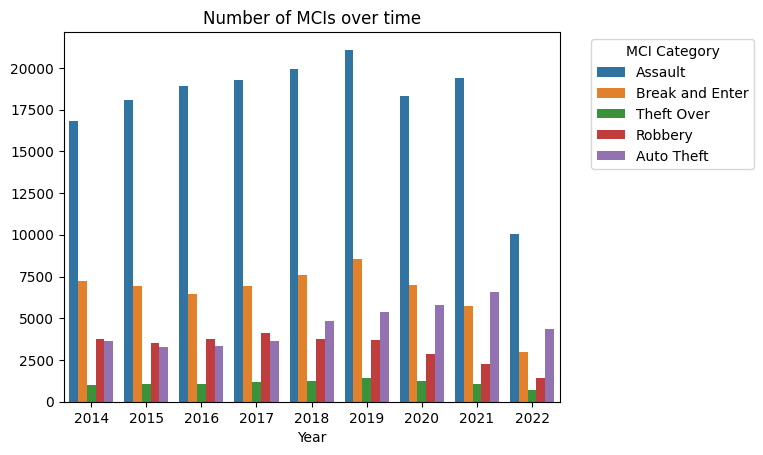

In [13]:
#No further cleaning should be done. Reusing old code
sns.countplot(data = dff, x='reportedyear' , hue = 'mci_category', orient = 'h')
plt.title("Number of MCIs over time")
plt.ylabel("")
plt.xlabel("Year")
plt.legend(title = "MCI Category",loc='upper left', bbox_to_anchor=(1.05, 1))

2022 might seem like a drastic shift, however it should be noted that the data only goes up to 2022 June. So about half the year is missing from the dataset. Normally, it would be excluded, but the initial half of the year could still provide value if we wanted to query based on month. That said, I probably should remove it. <br><br>

Regardless, assaults seemed to be trending over time, with the exception of 2020 and 2021, however those were also the years where the covid-19 restrictions occurred. Auto theft also appears to be trending upwards. Which will be later on in the analysis.

3.3 Defining Offences by Category

In [14]:
dff.groupby(['mci_category','offence'])['offence'].count()

mci_category     offence                       
Assault          Administering Noxious Thing          466
                 Aggravated Aslt Peace Officer         23
                 Aggravated Assault                  2483
                 Aggravated Assault Avails Pros        19
                 Air Gun Or Pistol: Bodily Harm        27
                 Assault                           110528
                 Assault - Force/Thrt/Impede          373
                 Assault - Resist/ Prevent Seiz      3018
                 Assault Bodily Harm                 7027
                 Assault Peace Officer               5174
                 Assault Peace Officer Wpn/Cbh        559
                 Assault With Weapon                27191
                 Crim Negligence Bodily Harm          106
                 Disarming Peace/Public Officer       108
                 Discharge Firearm - Recklessly      1441
                 Discharge Firearm With Intent       2003
                 Hoax Te

Results are fairly intuitive. Pretty much all categories of theft of motor vehicle don't specify what the theft is.
So there's no special section for catalytic converter theft, so it would be difficult to differentiate between those
and simple break ins.

3.4. Average length of time between crime and breakin

In [15]:
#Removing days when occurrence data isn't logged
dffnona = dff[dff['occurrenceday'].notnull()]

dffnona['occurrenceyear'] = dffnona['occurrenceyear'].astype(int)
dffnona['reportedyear'] = dffnona['reportedyear'].astype(int)

dffnona['occurrenceday'] = dffnona['occurrenceday'].astype(int)
dffnona['reportedday'] = dffnona['reportedday'].astype(int)

dffnona['occurrencehour'] = dffnona['occurrencehour'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x);
dffnona['reportedhour'] = dffnona['reportedhour'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x);
dffnona['occurrence_datetime'] = dffnona['occurrenceyear'].astype(str) + '-' + dffnona['occurrencemonth'] + '-' + dffnona['occurrenceday'].astype(str) + ' ' + dffnona['occurrencehour'] + ':00:00'
dffnona['reported_datetime'] = dffnona['reportedyear'].astype(str) + '-' + dffnona['reportedmonth'] + '-' + dffnona['reportedday'].astype(str) + ' ' + dffnona['reportedhour'] + ':00:00'

dffnona['occurrence_datetime'] = dffnona['occurrence_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%B-%d %H:%M:%S'));
dffnona['reported_datetime'] = dffnona['reported_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%B-%d %H:%M:%S'));

C:\Users\Justin\AppData\Local\Temp\ipykernel_11688\3093387523.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffnona['occurrenceyear'] = dffnona['occurrenceyear'].astype(int)
C:\Users\Justin\AppData\Local\Temp\ipykernel_11688\3093387523.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffnona['reportedyear'] = dffnona['reportedyear'].astype(int)
C:\Users\Justin\AppData\Local\Temp\ipykernel_11688\3093387523.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

C:\Users\Justin\AppData\Local\Temp\ipykernel_11688\3306276689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffnona['time_to_report'] = (dffnona['reported_datetime'] - dffnona['occurrence_datetime']).dt.total_seconds()/3600
C:\Users\Justin\AppData\Local\Temp\ipykernel_11688\3306276689.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffnona24['time_to_report'] = dffnona24['time_to_report'].astype(int)
c:\Users\Justin\miniconda3\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the count

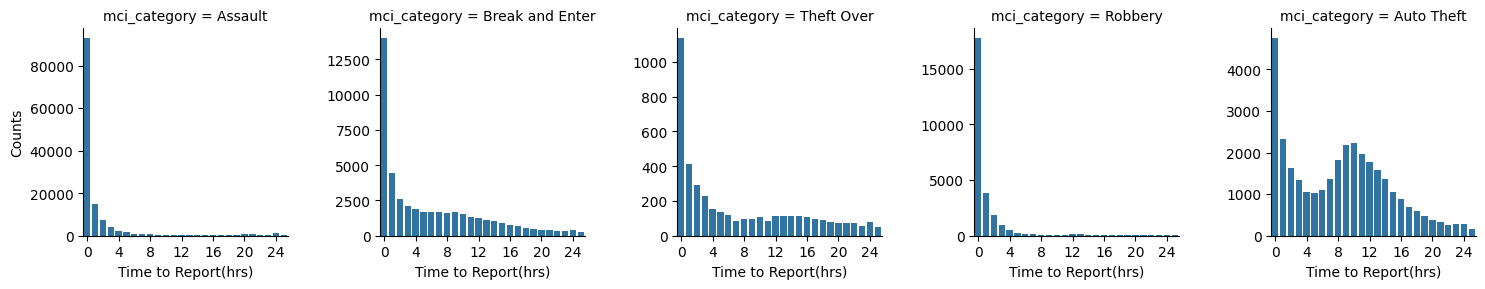

In [16]:
dffnona['time_to_report'] = (dffnona['reported_datetime'] - dffnona['occurrence_datetime']).dt.total_seconds()/3600
dffnona24 = dffnona[dffnona['time_to_report']<=25]
dffnona24['time_to_report'] = dffnona24['time_to_report'].astype(int)
cl = sns.FacetGrid(dffnona24, col ='mci_category', sharey = False)
cl.map(sns.countplot, 'time_to_report')
cl.set(xticks=[0,4,8,12,16,20,24])
cl.set_axis_labels("Time to Report(hrs)", "Counts")

From the first 24 hours, most reports are filed immediately. With the exception of autotheft, where there is an increase in reports starting at the 8 hour mark and plateauing at the 10 hour mark. 

3.5 Which division is best at their jobs?

In [17]:
dff.groupby('division')['division'].count().sort_values(ascending = False)

#High D51,D32,D31. Low D13,D54, NSA

result = dff[dff['division'].isin(['D51','D32','D31'])].groupby(['division','neighbourhood']).count().reset_index()
result.sort_values(by=['division','event_unique_id'], ascending=False);

D51 primarily services 3 of the top 5 areas with the most crimes Waterfront Communities-The Island, Church-Yonge Corridor, Moss Park. This could open up investigations into the area and why the crime rate might be so high.

3.6.  After some basic queries that might frame some considerations a migrant would have before moving to Toronto, we want to know where car thefts happen, and the most common time of their occurrence.

In [18]:
dff[dff['mci_category'] == 'Auto Theft'].groupby('neighbourhood')['neighbourhood'].count().sort_values(ascending = False).nlargest(3)
#top 3 neighborhoods for autotheft: West Humber-Clairville, Islington-City Centre West, York University Heights
dff[dff['mci_category'] == 'Auto Theft'].groupby('occurrencedayofweek')['occurrencedayofweek'].count()
#Weekends typically have a lower case of car theft. Assuming people don't have to commute to work.
dff[dff['mci_category'] == 'Auto Theft'].groupby('occurrencehour')['occurrencehour'].count().sort_values(ascending = False)
#Most commonly performed in night hours (6pm-12) or times when people won't be driving.
dff[dff['mci_category'] == 'Auto Theft'].groupby('location_type')['location_type'].count().sort_values(ascending = False);
#Most car thefts are in parking lots, commercial homes, or streets. Which sounds pretty basic, but its still good to know

Bonus Round! <br>
So now that we know all of this, what if you can't afford an entire house, and want to find the best apartment with the least sketchy neighborhood?

In [19]:
dff[dff['occurrenceyear'] == 2021][dff['premises_type'] == 'Apartment'][dff['mci_category']== 'Assault'].groupby('neighbourhood')['neighbourhood'].count().sort_values(ascending = False)

C:\Users\Justin\AppData\Local\Temp\ipykernel_11688\2162720879.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dff[dff['occurrenceyear'] == 2021][dff['premises_type'] == 'Apartment'][dff['mci_category']== 'Assault'].groupby('neighbourhood')['neighbourhood'].count().sort_values(ascending = False)


neighbourhood
Waterfront Communities-The Island    267
Moss Park                            224
Church-Yonge Corridor                192
North St.James Town                  162
Downsview-Roding-CFB                 146
                                    ... 
Centennial Scarborough                 4
Kingsway South                         2
Guildwood                              2
Lawrence Park North                    2
Princess-Rosethorn                     1
Name: neighbourhood, Length: 141, dtype: int64

In [20]:
dff

,event_unique_id,division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,ucr_ext,offence,reportedyear,...,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,hood_id,neighbourhood,longitude,latitude
0,GO-20141273318,D31,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Apartment (Rooming House, Condo)",Apartment,1430,100,Assault,2014,...,January,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371
1,GO-20141274349,D42,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,200,B&E,2014,...,January,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861
2,GO-20141274052,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,100,Assault,2014,...,January,3.0,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085
3,GO-20141276966,D53,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,210,Theft Over,2014,...,January,3.0,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212
4,GO-20141274457,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Convenience Stores,Commercial,1610,210,Robbery - Business,2014,...,January,3.0,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301228,GO-20221234233,D32,2022/06/28 04:00:00+00,2022/06/29 04:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2135,210,Theft Of Motor Vehicle,2022,...,June,28.0,179.0,Tuesday,20,Auto Theft,35,Westminster-Branson,-79.455098,43.790363
301229,GO-20221234061,D43,2022/06/28 04:00:00+00,2022/06/29 04:00:00+00,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2135,210,Theft Of Motor Vehicle,2022,...,June,28.0,179.0,Tuesday,21,Auto Theft,137,Woburn,-79.234954,43.775740
301230,GO-20221234664,D41,2022/05/20 04:00:00+00,2022/06/29 04:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2135,210,Theft Of Motor Vehicle,2022,...,May,20.0,140.0,Friday,12,Auto Theft,126,Dorset Park,-79.281037,43.765801
301231,GO-20221235156,D41,2022/06/29 04:00:00+00,2022/06/29 04:00:00+00,"Parking Lots (Apt., Commercial Or Non-Commercial)",Outside,2135,210,Theft Of Motor Vehicle,2022,...,June,29.0,180.0,Wednesday,0,Auto Theft,NSA,NSA,0.000000,0.000000
